# AnoGAN
- 2020.08.11 : Genrator 학습 수 ... 4

# 개발일지
- 2020.08.14 : 분율 추출 구현
- 2020.08.15 : 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티티늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100 # z벡터의 잠재공간(latent space)의 크기
workers = 4 # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
data_root = "../../../OhSeHyeon/source/dataset/aug_train"

data_set = dataset.ImageFolder(root = data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 920
device : cuda:0


# MODEL

In [4]:
# Generative Adversarial Networks Model

# === Generator 모델 ===
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def G_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.G_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *G_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *G_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *G_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *G_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.G_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1 , 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.G_gen_distribution(input)
        fake_img = self.G_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, BN=True):
            if BN:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True)
                ]
            return block
        
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, BN=False),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, BN=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, BN=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, BN=True)
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
G_losses = []
D_losses = []
iters = 0

def train(epoch, learning_G_per_D):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train Discriminator
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = G(z)
        fake_classification, _ = D(fake_img) # output = D(G(z))
        fake_loss = criterion(fake_classification, fake_labels) # D(G(z))=0일 때의 loss
        fake_score = fake_classification
        D_G_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss 
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적

        
        # Train Generater
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_G_per_D):
            fake_img = G(z)
            fake_classification, _ = D(fake_img)  # output : D(G(z))
            D_G_z2 = fake_classification.mean().item()
            G_loss = criterion(fake_classification, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            G_loss.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적
            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / G_loss : %.4f\n- D(x) : %.4f / D(G(z1)) : %.4f / D(G(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     G_loss.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

In [7]:
for epoch in range(epochs):
    train(epoch, learning_G_per_D = 15)

/home/piai/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/14]
- D_loss : 1.3804 / G_loss : 0.6688
- D(x) : 0.5043 / D(G(z1)) : 0.5013 / D(G(z2)) : 0.5123
[1/100][1/14]
- D_loss : 1.3860 / G_loss : 0.6581
- D(x) : 0.5058 / D(G(z1)) : 0.5056 / D(G(z2)) : 0.5179
[1/100][2/14]
- D_loss : 1.3957 / G_loss : 0.6478
- D(x) : 0.5061 / D(G(z1)) : 0.5106 / D(G(z2)) : 0.5232
[1/100][3/14]
- D_loss : 1.4008 / G_loss : 0.6402
- D(x) : 0.5079 / D(G(z1)) : 0.5148 / D(G(z2)) : 0.5272
[1/100][4/14]
- D_loss : 1.4127 / G_loss : 0.6303
- D(x) : 0.5076 / D(G(z1)) : 0.5203 / D(G(z2)) : 0.5324
[1/100][5/14]
- D_loss : 1.4234 / G_loss : 0.6208
- D(x) : 0.5083 / D(G(z1)) : 0.5261 / D(G(z2)) : 0.5375
[1/100][6/14]
- D_loss : 1.4356 / G_loss : 0.6119
- D(x) : 0.5080 / D(G(z1)) : 0.5315 / D(G(z2)) : 0.5423
[1/100][7/14]
- D_loss : 1.4481 / G_loss : 0.6033
- D(x) : 0.5077 / D(G(z1)) : 0.5370 / D(G(z2)) : 0.5470
[1/100][8/14]
- D_loss : 1.4564 / G_loss : 0.5964
- D(x) : 0.5087 / D(G(z1)) : 0.5418 / D(G(z2)) : 0.5508
[1/100][9/14]
- D_loss : 1.4650 / G_loss : 0.5

[6/100][8/14]
- D_loss : 1.5765 / G_loss : 0.5041
- D(x) : 0.5204 / D(G(z1)) : 0.6027 / D(G(z2)) : 0.6041
[6/100][9/14]
- D_loss : 1.5808 / G_loss : 0.5038
- D(x) : 0.5182 / D(G(z1)) : 0.6027 / D(G(z2)) : 0.6042
[6/100][10/14]
- D_loss : 1.5793 / G_loss : 0.5039
- D(x) : 0.5189 / D(G(z1)) : 0.6027 / D(G(z2)) : 0.6042
[6/100][11/14]
- D_loss : 1.5803 / G_loss : 0.5034
- D(x) : 0.5183 / D(G(z1)) : 0.6026 / D(G(z2)) : 0.6045
[6/100][12/14]
- D_loss : 1.5761 / G_loss : 0.5026
- D(x) : 0.5213 / D(G(z1)) : 0.6032 / D(G(z2)) : 0.6050
[6/100][13/14]
- D_loss : 1.5830 / G_loss : 0.5024
- D(x) : 0.5181 / D(G(z1)) : 0.6035 / D(G(z2)) : 0.6051
[7/100][0/14]
- D_loss : 1.5806 / G_loss : 0.5015
- D(x) : 0.5201 / D(G(z1)) : 0.6041 / D(G(z2)) : 0.6057
[7/100][1/14]
- D_loss : 1.5824 / G_loss : 0.5004
- D(x) : 0.5196 / D(G(z1)) : 0.6045 / D(G(z2)) : 0.6063
[7/100][2/14]
- D_loss : 1.5844 / G_loss : 0.5003
- D(x) : 0.5185 / D(G(z1)) : 0.6044 / D(G(z2)) : 0.6064
[7/100][3/14]
- D_loss : 1.5855 / G_loss :

[12/100][1/14]
- D_loss : 1.6418 / G_loss : 0.4613
- D(x) : 0.5221 / D(G(z1)) : 0.6290 / D(G(z2)) : 0.6305
[12/100][2/14]
- D_loss : 1.6403 / G_loss : 0.4622
- D(x) : 0.5218 / D(G(z1)) : 0.6283 / D(G(z2)) : 0.6299
[12/100][3/14]
- D_loss : 1.6405 / G_loss : 0.4627
- D(x) : 0.5217 / D(G(z1)) : 0.6283 / D(G(z2)) : 0.6296
[12/100][4/14]
- D_loss : 1.6365 / G_loss : 0.4631
- D(x) : 0.5230 / D(G(z1)) : 0.6277 / D(G(z2)) : 0.6293
[12/100][5/14]
- D_loss : 1.6417 / G_loss : 0.4629
- D(x) : 0.5206 / D(G(z1)) : 0.6279 / D(G(z2)) : 0.6295
[12/100][6/14]
- D_loss : 1.6327 / G_loss : 0.4631
- D(x) : 0.5251 / D(G(z1)) : 0.6278 / D(G(z2)) : 0.6293
[12/100][7/14]
- D_loss : 1.6367 / G_loss : 0.4633
- D(x) : 0.5231 / D(G(z1)) : 0.6278 / D(G(z2)) : 0.6292
[12/100][8/14]
- D_loss : 1.6359 / G_loss : 0.4642
- D(x) : 0.5229 / D(G(z1)) : 0.6274 / D(G(z2)) : 0.6287
[12/100][9/14]
- D_loss : 1.6383 / G_loss : 0.4650
- D(x) : 0.5213 / D(G(z1)) : 0.6271 / D(G(z2)) : 0.6281
[12/100][10/14]
- D_loss : 1.6355 / G

[17/100][8/14]
- D_loss : 1.5977 / G_loss : 0.4875
- D(x) : 0.5234 / D(G(z1)) : 0.6132 / D(G(z2)) : 0.6141
[17/100][9/14]
- D_loss : 1.5969 / G_loss : 0.4874
- D(x) : 0.5235 / D(G(z1)) : 0.6130 / D(G(z2)) : 0.6142
[17/100][10/14]
- D_loss : 1.5989 / G_loss : 0.4876
- D(x) : 0.5226 / D(G(z1)) : 0.6132 / D(G(z2)) : 0.6141
[17/100][11/14]
- D_loss : 1.5912 / G_loss : 0.4880
- D(x) : 0.5263 / D(G(z1)) : 0.6129 / D(G(z2)) : 0.6139
[17/100][12/14]
- D_loss : 1.5978 / G_loss : 0.4878
- D(x) : 0.5231 / D(G(z1)) : 0.6131 / D(G(z2)) : 0.6140
[17/100][13/14]
- D_loss : 1.5947 / G_loss : 0.4879
- D(x) : 0.5248 / D(G(z1)) : 0.6130 / D(G(z2)) : 0.6139
[18/100][0/14]
- D_loss : 1.5955 / G_loss : 0.4882
- D(x) : 0.5239 / D(G(z1)) : 0.6128 / D(G(z2)) : 0.6137
[18/100][1/14]
- D_loss : 1.5940 / G_loss : 0.4887
- D(x) : 0.5244 / D(G(z1)) : 0.6126 / D(G(z2)) : 0.6134
[18/100][2/14]
- D_loss : 1.5909 / G_loss : 0.4894
- D(x) : 0.5255 / D(G(z1)) : 0.6122 / D(G(z2)) : 0.6130
[18/100][3/14]
- D_loss : 1.5910 

[23/100][1/14]
- D_loss : 1.5516 / G_loss : 0.5099
- D(x) : 0.5302 / D(G(z1)) : 0.6001 / D(G(z2)) : 0.6006
[23/100][2/14]
- D_loss : 1.5581 / G_loss : 0.5105
- D(x) : 0.5260 / D(G(z1)) : 0.5996 / D(G(z2)) : 0.6002
[23/100][3/14]
- D_loss : 1.5575 / G_loss : 0.5110
- D(x) : 0.5260 / D(G(z1)) : 0.5994 / D(G(z2)) : 0.5999
[23/100][4/14]
- D_loss : 1.5544 / G_loss : 0.5115
- D(x) : 0.5275 / D(G(z1)) : 0.5992 / D(G(z2)) : 0.5996
[23/100][5/14]
- D_loss : 1.5566 / G_loss : 0.5122
- D(x) : 0.5258 / D(G(z1)) : 0.5989 / D(G(z2)) : 0.5992
[23/100][6/14]
- D_loss : 1.5514 / G_loss : 0.5130
- D(x) : 0.5278 / D(G(z1)) : 0.5982 / D(G(z2)) : 0.5987
[23/100][7/14]
- D_loss : 1.5506 / G_loss : 0.5135
- D(x) : 0.5278 / D(G(z1)) : 0.5980 / D(G(z2)) : 0.5984
[23/100][8/14]
- D_loss : 1.5572 / G_loss : 0.5140
- D(x) : 0.5239 / D(G(z1)) : 0.5976 / D(G(z2)) : 0.5981
[23/100][9/14]
- D_loss : 1.5536 / G_loss : 0.5146
- D(x) : 0.5254 / D(G(z1)) : 0.5973 / D(G(z2)) : 0.5978
[23/100][10/14]
- D_loss : 1.5531 / G

[28/100][8/14]
- D_loss : 1.5391 / G_loss : 0.5215
- D(x) : 0.5279 / D(G(z1)) : 0.5932 / D(G(z2)) : 0.5936
[28/100][9/14]
- D_loss : 1.5328 / G_loss : 0.5221
- D(x) : 0.5307 / D(G(z1)) : 0.5929 / D(G(z2)) : 0.5933
[28/100][10/14]
- D_loss : 1.5374 / G_loss : 0.5230
- D(x) : 0.5277 / D(G(z1)) : 0.5925 / D(G(z2)) : 0.5927
[28/100][11/14]
- D_loss : 1.5358 / G_loss : 0.5241
- D(x) : 0.5279 / D(G(z1)) : 0.5920 / D(G(z2)) : 0.5921
[28/100][12/14]
- D_loss : 1.5310 / G_loss : 0.5251
- D(x) : 0.5297 / D(G(z1)) : 0.5913 / D(G(z2)) : 0.5915
[28/100][13/14]
- D_loss : 1.5305 / G_loss : 0.5258
- D(x) : 0.5292 / D(G(z1)) : 0.5909 / D(G(z2)) : 0.5911
[29/100][0/14]
- D_loss : 1.5300 / G_loss : 0.5267
- D(x) : 0.5292 / D(G(z1)) : 0.5905 / D(G(z2)) : 0.5905
[29/100][1/14]
- D_loss : 1.5236 / G_loss : 0.5279
- D(x) : 0.5315 / D(G(z1)) : 0.5897 / D(G(z2)) : 0.5899
[29/100][2/14]
- D_loss : 1.5276 / G_loss : 0.5288
- D(x) : 0.5287 / D(G(z1)) : 0.5893 / D(G(z2)) : 0.5893
[29/100][3/14]
- D_loss : 1.5258 

[34/100][1/14]
- D_loss : 1.4948 / G_loss : 0.5485
- D(x) : 0.5313 / D(G(z1)) : 0.5776 / D(G(z2)) : 0.5778
[34/100][2/14]
- D_loss : 1.5025 / G_loss : 0.5489
- D(x) : 0.5271 / D(G(z1)) : 0.5775 / D(G(z2)) : 0.5776
[34/100][3/14]
- D_loss : 1.4961 / G_loss : 0.5492
- D(x) : 0.5299 / D(G(z1)) : 0.5770 / D(G(z2)) : 0.5774
[34/100][4/14]
- D_loss : 1.4981 / G_loss : 0.5486
- D(x) : 0.5288 / D(G(z1)) : 0.5770 / D(G(z2)) : 0.5778
[34/100][5/14]
- D_loss : 1.4990 / G_loss : 0.5484
- D(x) : 0.5287 / D(G(z1)) : 0.5773 / D(G(z2)) : 0.5779
[34/100][6/14]
- D_loss : 1.5045 / G_loss : 0.5485
- D(x) : 0.5257 / D(G(z1)) : 0.5772 / D(G(z2)) : 0.5778
[34/100][7/14]
- D_loss : 1.4991 / G_loss : 0.5481
- D(x) : 0.5288 / D(G(z1)) : 0.5774 / D(G(z2)) : 0.5781
[34/100][8/14]
- D_loss : 1.5056 / G_loss : 0.5479
- D(x) : 0.5256 / D(G(z1)) : 0.5777 / D(G(z2)) : 0.5782
[34/100][9/14]
- D_loss : 1.5002 / G_loss : 0.5480
- D(x) : 0.5286 / D(G(z1)) : 0.5777 / D(G(z2)) : 0.5781
[34/100][10/14]
- D_loss : 1.5003 / G

[39/100][8/14]
- D_loss : 1.4724 / G_loss : 0.5723
- D(x) : 0.5260 / D(G(z1)) : 0.5637 / D(G(z2)) : 0.5642
[39/100][9/14]
- D_loss : 1.4708 / G_loss : 0.5725
- D(x) : 0.5270 / D(G(z1)) : 0.5638 / D(G(z2)) : 0.5641
[39/100][10/14]
- D_loss : 1.4786 / G_loss : 0.5733
- D(x) : 0.5227 / D(G(z1)) : 0.5636 / D(G(z2)) : 0.5637
[39/100][11/14]
- D_loss : 1.4770 / G_loss : 0.5741
- D(x) : 0.5230 / D(G(z1)) : 0.5632 / D(G(z2)) : 0.5632
[39/100][12/14]
- D_loss : 1.4779 / G_loss : 0.5749
- D(x) : 0.5218 / D(G(z1)) : 0.5627 / D(G(z2)) : 0.5628
[39/100][13/14]
- D_loss : 1.4695 / G_loss : 0.5753
- D(x) : 0.5259 / D(G(z1)) : 0.5623 / D(G(z2)) : 0.5625
[40/100][0/14]
- D_loss : 1.4677 / G_loss : 0.5756
- D(x) : 0.5266 / D(G(z1)) : 0.5621 / D(G(z2)) : 0.5623
[40/100][1/14]
- D_loss : 1.4730 / G_loss : 0.5759
- D(x) : 0.5235 / D(G(z1)) : 0.5619 / D(G(z2)) : 0.5622
[40/100][2/14]
- D_loss : 1.4712 / G_loss : 0.5760
- D(x) : 0.5243 / D(G(z1)) : 0.5618 / D(G(z2)) : 0.5622
[40/100][3/14]
- D_loss : 1.4717 

[45/100][1/14]
- D_loss : 1.4566 / G_loss : 0.5872
- D(x) : 0.5243 / D(G(z1)) : 0.5553 / D(G(z2)) : 0.5559
[45/100][2/14]
- D_loss : 1.4581 / G_loss : 0.5869
- D(x) : 0.5238 / D(G(z1)) : 0.5555 / D(G(z2)) : 0.5561
[45/100][3/14]
- D_loss : 1.4600 / G_loss : 0.5865
- D(x) : 0.5229 / D(G(z1)) : 0.5556 / D(G(z2)) : 0.5563
[45/100][4/14]
- D_loss : 1.4611 / G_loss : 0.5859
- D(x) : 0.5226 / D(G(z1)) : 0.5559 / D(G(z2)) : 0.5566
[45/100][5/14]
- D_loss : 1.4576 / G_loss : 0.5858
- D(x) : 0.5246 / D(G(z1)) : 0.5560 / D(G(z2)) : 0.5567
[45/100][6/14]
- D_loss : 1.4616 / G_loss : 0.5859
- D(x) : 0.5230 / D(G(z1)) : 0.5563 / D(G(z2)) : 0.5566
[45/100][7/14]
- D_loss : 1.4585 / G_loss : 0.5862
- D(x) : 0.5244 / D(G(z1)) : 0.5562 / D(G(z2)) : 0.5564
[45/100][8/14]
- D_loss : 1.4570 / G_loss : 0.5865
- D(x) : 0.5251 / D(G(z1)) : 0.5560 / D(G(z2)) : 0.5563
[45/100][9/14]
- D_loss : 1.4580 / G_loss : 0.5869
- D(x) : 0.5240 / D(G(z1)) : 0.5558 / D(G(z2)) : 0.5560
[45/100][10/14]
- D_loss : 1.4629 / G

[50/100][8/14]
- D_loss : 1.4291 / G_loss : 0.6078
- D(x) : 0.5255 / D(G(z1)) : 0.5439 / D(G(z2)) : 0.5445
[50/100][9/14]
- D_loss : 1.4322 / G_loss : 0.6079
- D(x) : 0.5243 / D(G(z1)) : 0.5441 / D(G(z2)) : 0.5445
[50/100][10/14]
- D_loss : 1.4332 / G_loss : 0.6083
- D(x) : 0.5236 / D(G(z1)) : 0.5441 / D(G(z2)) : 0.5443
[50/100][11/14]
- D_loss : 1.4306 / G_loss : 0.6091
- D(x) : 0.5246 / D(G(z1)) : 0.5438 / D(G(z2)) : 0.5438
[50/100][12/14]
- D_loss : 1.4233 / G_loss : 0.6098
- D(x) : 0.5280 / D(G(z1)) : 0.5434 / D(G(z2)) : 0.5434
[50/100][13/14]
- D_loss : 1.4227 / G_loss : 0.6104
- D(x) : 0.5278 / D(G(z1)) : 0.5430 / D(G(z2)) : 0.5432
[51/100][0/14]
- D_loss : 1.4280 / G_loss : 0.6111
- D(x) : 0.5248 / D(G(z1)) : 0.5428 / D(G(z2)) : 0.5427
[51/100][1/14]
- D_loss : 1.4269 / G_loss : 0.6116
- D(x) : 0.5251 / D(G(z1)) : 0.5423 / D(G(z2)) : 0.5425
[51/100][2/14]
- D_loss : 1.4217 / G_loss : 0.6122
- D(x) : 0.5272 / D(G(z1)) : 0.5421 / D(G(z2)) : 0.5422
[51/100][3/14]
- D_loss : 1.4229 

[56/100][1/14]
- D_loss : 1.4194 / G_loss : 0.6181
- D(x) : 0.5248 / D(G(z1)) : 0.5387 / D(G(z2)) : 0.5389
[56/100][2/14]
- D_loss : 1.4223 / G_loss : 0.6182
- D(x) : 0.5233 / D(G(z1)) : 0.5388 / D(G(z2)) : 0.5389
[56/100][3/14]
- D_loss : 1.4178 / G_loss : 0.6182
- D(x) : 0.5256 / D(G(z1)) : 0.5388 / D(G(z2)) : 0.5389
[56/100][4/14]
- D_loss : 1.4237 / G_loss : 0.6181
- D(x) : 0.5227 / D(G(z1)) : 0.5388 / D(G(z2)) : 0.5389
[56/100][5/14]
- D_loss : 1.4183 / G_loss : 0.6183
- D(x) : 0.5253 / D(G(z1)) : 0.5388 / D(G(z2)) : 0.5388
[56/100][6/14]
- D_loss : 1.4195 / G_loss : 0.6189
- D(x) : 0.5245 / D(G(z1)) : 0.5387 / D(G(z2)) : 0.5386
[56/100][7/14]
- D_loss : 1.4174 / G_loss : 0.6194
- D(x) : 0.5254 / D(G(z1)) : 0.5384 / D(G(z2)) : 0.5383
[56/100][8/14]
- D_loss : 1.4201 / G_loss : 0.6201
- D(x) : 0.5237 / D(G(z1)) : 0.5381 / D(G(z2)) : 0.5379
[56/100][9/14]
- D_loss : 1.4131 / G_loss : 0.6200
- D(x) : 0.5268 / D(G(z1)) : 0.5378 / D(G(z2)) : 0.5379
[56/100][10/14]
- D_loss : 1.4178 / G

[61/100][8/14]
- D_loss : 1.3947 / G_loss : 0.6550
- D(x) : 0.5164 / D(G(z1)) : 0.5197 / D(G(z2)) : 0.5194
[61/100][9/14]
- D_loss : 1.3951 / G_loss : 0.6558
- D(x) : 0.5157 / D(G(z1)) : 0.5194 / D(G(z2)) : 0.5190
[61/100][10/14]
- D_loss : 1.3971 / G_loss : 0.6566
- D(x) : 0.5143 / D(G(z1)) : 0.5189 / D(G(z2)) : 0.5186
[61/100][11/14]
- D_loss : 1.3984 / G_loss : 0.6574
- D(x) : 0.5132 / D(G(z1)) : 0.5185 / D(G(z2)) : 0.5182
[61/100][12/14]
- D_loss : 1.3888 / G_loss : 0.6581
- D(x) : 0.5178 / D(G(z1)) : 0.5181 / D(G(z2)) : 0.5178
[61/100][13/14]
- D_loss : 1.3886 / G_loss : 0.6587
- D(x) : 0.5174 / D(G(z1)) : 0.5177 / D(G(z2)) : 0.5175
[62/100][0/14]
- D_loss : 1.3898 / G_loss : 0.6590
- D(x) : 0.5165 / D(G(z1)) : 0.5174 / D(G(z2)) : 0.5173
[62/100][1/14]
- D_loss : 1.3931 / G_loss : 0.6592
- D(x) : 0.5147 / D(G(z1)) : 0.5173 / D(G(z2)) : 0.5173
[62/100][2/14]
- D_loss : 1.3957 / G_loss : 0.6588
- D(x) : 0.5133 / D(G(z1)) : 0.5172 / D(G(z2)) : 0.5175
[62/100][3/14]
- D_loss : 1.3911 

[67/100][1/14]
- D_loss : 1.4088 / G_loss : 0.6452
- D(x) : 0.5149 / D(G(z1)) : 0.5250 / D(G(z2)) : 0.5245
[67/100][2/14]
- D_loss : 1.4065 / G_loss : 0.6465
- D(x) : 0.5153 / D(G(z1)) : 0.5244 / D(G(z2)) : 0.5239
[67/100][3/14]
- D_loss : 1.4039 / G_loss : 0.6473
- D(x) : 0.5161 / D(G(z1)) : 0.5238 / D(G(z2)) : 0.5235
[67/100][4/14]
- D_loss : 1.4088 / G_loss : 0.6481
- D(x) : 0.5131 / D(G(z1)) : 0.5233 / D(G(z2)) : 0.5230
[67/100][5/14]
- D_loss : 1.4058 / G_loss : 0.6489
- D(x) : 0.5141 / D(G(z1)) : 0.5229 / D(G(z2)) : 0.5226
[67/100][6/14]
- D_loss : 1.4011 / G_loss : 0.6495
- D(x) : 0.5161 / D(G(z1)) : 0.5225 / D(G(z2)) : 0.5223
[67/100][7/14]
- D_loss : 1.3995 / G_loss : 0.6500
- D(x) : 0.5166 / D(G(z1)) : 0.5222 / D(G(z2)) : 0.5221
[67/100][8/14]
- D_loss : 1.4128 / G_loss : 0.6507
- D(x) : 0.5095 / D(G(z1)) : 0.5219 / D(G(z2)) : 0.5217
[67/100][9/14]
- D_loss : 1.4039 / G_loss : 0.6516
- D(x) : 0.5136 / D(G(z1)) : 0.5215 / D(G(z2)) : 0.5212
[67/100][10/14]
- D_loss : 1.4011 / G

[72/100][8/14]
- D_loss : 1.4206 / G_loss : 0.6469
- D(x) : 0.5074 / D(G(z1)) : 0.5238 / D(G(z2)) : 0.5237
[72/100][9/14]
- D_loss : 1.4132 / G_loss : 0.6472
- D(x) : 0.5110 / D(G(z1)) : 0.5236 / D(G(z2)) : 0.5235
[72/100][10/14]
- D_loss : 1.4169 / G_loss : 0.6476
- D(x) : 0.5089 / D(G(z1)) : 0.5234 / D(G(z2)) : 0.5233
[72/100][11/14]
- D_loss : 1.4165 / G_loss : 0.6482
- D(x) : 0.5089 / D(G(z1)) : 0.5232 / D(G(z2)) : 0.5230
[72/100][12/14]
- D_loss : 1.4174 / G_loss : 0.6490
- D(x) : 0.5080 / D(G(z1)) : 0.5229 / D(G(z2)) : 0.5226
[72/100][13/14]
- D_loss : 1.4079 / G_loss : 0.6500
- D(x) : 0.5125 / D(G(z1)) : 0.5225 / D(G(z2)) : 0.5221
[73/100][0/14]
- D_loss : 1.4138 / G_loss : 0.6510
- D(x) : 0.5090 / D(G(z1)) : 0.5220 / D(G(z2)) : 0.5215
[73/100][1/14]
- D_loss : 1.4119 / G_loss : 0.6522
- D(x) : 0.5093 / D(G(z1)) : 0.5214 / D(G(z2)) : 0.5209
[73/100][2/14]
- D_loss : 1.4117 / G_loss : 0.6534
- D(x) : 0.5087 / D(G(z1)) : 0.5208 / D(G(z2)) : 0.5203
[73/100][3/14]
- D_loss : 1.4083 

[78/100][1/14]
- D_loss : 1.4059 / G_loss : 0.6613
- D(x) : 0.5073 / D(G(z1)) : 0.5166 / D(G(z2)) : 0.5162
[78/100][2/14]
- D_loss : 1.4046 / G_loss : 0.6624
- D(x) : 0.5074 / D(G(z1)) : 0.5161 / D(G(z2)) : 0.5156
[78/100][3/14]
- D_loss : 1.4057 / G_loss : 0.6636
- D(x) : 0.5062 / D(G(z1)) : 0.5156 / D(G(z2)) : 0.5150
[78/100][4/14]
- D_loss : 1.3995 / G_loss : 0.6648
- D(x) : 0.5088 / D(G(z1)) : 0.5149 / D(G(z2)) : 0.5144
[78/100][5/14]
- D_loss : 1.4076 / G_loss : 0.6660
- D(x) : 0.5040 / D(G(z1)) : 0.5143 / D(G(z2)) : 0.5138
[78/100][6/14]
- D_loss : 1.3993 / G_loss : 0.6673
- D(x) : 0.5076 / D(G(z1)) : 0.5137 / D(G(z2)) : 0.5131
[78/100][7/14]
- D_loss : 1.4006 / G_loss : 0.6687
- D(x) : 0.5062 / D(G(z1)) : 0.5131 / D(G(z2)) : 0.5124
[78/100][8/14]
- D_loss : 1.4034 / G_loss : 0.6700
- D(x) : 0.5040 / D(G(z1)) : 0.5123 / D(G(z2)) : 0.5117
[78/100][9/14]
- D_loss : 1.3953 / G_loss : 0.6713
- D(x) : 0.5074 / D(G(z1)) : 0.5117 / D(G(z2)) : 0.5110
[78/100][10/14]
- D_loss : 1.3947 / G

[83/100][8/14]
- D_loss : 1.3953 / G_loss : 0.6738
- D(x) : 0.5052 / D(G(z1)) : 0.5095 / D(G(z2)) : 0.5098
[83/100][9/14]
- D_loss : 1.3875 / G_loss : 0.6743
- D(x) : 0.5092 / D(G(z1)) : 0.5095 / D(G(z2)) : 0.5095
[83/100][10/14]
- D_loss : 1.3857 / G_loss : 0.6748
- D(x) : 0.5100 / D(G(z1)) : 0.5094 / D(G(z2)) : 0.5092
[83/100][11/14]
- D_loss : 1.3882 / G_loss : 0.6746
- D(x) : 0.5084 / D(G(z1)) : 0.5090 / D(G(z2)) : 0.5094
[83/100][12/14]
- D_loss : 1.3882 / G_loss : 0.6747
- D(x) : 0.5085 / D(G(z1)) : 0.5092 / D(G(z2)) : 0.5093
[83/100][13/14]
- D_loss : 1.3856 / G_loss : 0.6750
- D(x) : 0.5098 / D(G(z1)) : 0.5091 / D(G(z2)) : 0.5092
[84/100][0/14]
- D_loss : 1.3875 / G_loss : 0.6754
- D(x) : 0.5086 / D(G(z1)) : 0.5089 / D(G(z2)) : 0.5090
[84/100][1/14]
- D_loss : 1.3891 / G_loss : 0.6755
- D(x) : 0.5075 / D(G(z1)) : 0.5087 / D(G(z2)) : 0.5089
[84/100][2/14]
- D_loss : 1.3896 / G_loss : 0.6755
- D(x) : 0.5073 / D(G(z1)) : 0.5087 / D(G(z2)) : 0.5089
[84/100][3/14]
- D_loss : 1.3824 

[89/100][1/14]
- D_loss : 1.3372 / G_loss : 0.6996
- D(x) : 0.5217 / D(G(z1)) : 0.4962 / D(G(z2)) : 0.4968
[89/100][2/14]
- D_loss : 1.3316 / G_loss : 0.6997
- D(x) : 0.5249 / D(G(z1)) : 0.4965 / D(G(z2)) : 0.4967
[89/100][3/14]
- D_loss : 1.3364 / G_loss : 0.6997
- D(x) : 0.5223 / D(G(z1)) : 0.4965 / D(G(z2)) : 0.4967
[89/100][4/14]
- D_loss : 1.3384 / G_loss : 0.6999
- D(x) : 0.5215 / D(G(z1)) : 0.4965 / D(G(z2)) : 0.4967
[89/100][5/14]
- D_loss : 1.3335 / G_loss : 0.7005
- D(x) : 0.5238 / D(G(z1)) : 0.4964 / D(G(z2)) : 0.4963
[89/100][6/14]
- D_loss : 1.3310 / G_loss : 0.7014
- D(x) : 0.5247 / D(G(z1)) : 0.4961 / D(G(z2)) : 0.4959
[89/100][7/14]
- D_loss : 1.3317 / G_loss : 0.7023
- D(x) : 0.5238 / D(G(z1)) : 0.4955 / D(G(z2)) : 0.4955
[89/100][8/14]
- D_loss : 1.3308 / G_loss : 0.7027
- D(x) : 0.5239 / D(G(z1)) : 0.4952 / D(G(z2)) : 0.4953
[89/100][9/14]
- D_loss : 1.3325 / G_loss : 0.7029
- D(x) : 0.5230 / D(G(z1)) : 0.4950 / D(G(z2)) : 0.4951
[89/100][10/14]
- D_loss : 1.3278 / G

[94/100][8/14]
- D_loss : 1.3834 / G_loss : 0.6666
- D(x) : 0.5164 / D(G(z1)) : 0.5143 / D(G(z2)) : 0.5134
[94/100][9/14]
- D_loss : 1.3766 / G_loss : 0.6684
- D(x) : 0.5191 / D(G(z1)) : 0.5134 / D(G(z2)) : 0.5126
[94/100][10/14]
- D_loss : 1.3769 / G_loss : 0.6701
- D(x) : 0.5180 / D(G(z1)) : 0.5126 / D(G(z2)) : 0.5116
[94/100][11/14]
- D_loss : 1.3732 / G_loss : 0.6720
- D(x) : 0.5189 / D(G(z1)) : 0.5116 / D(G(z2)) : 0.5107
[94/100][12/14]
- D_loss : 1.3746 / G_loss : 0.6738
- D(x) : 0.5173 / D(G(z1)) : 0.5107 / D(G(z2)) : 0.5098
[94/100][13/14]
- D_loss : 1.3728 / G_loss : 0.6756
- D(x) : 0.5171 / D(G(z1)) : 0.5098 / D(G(z2)) : 0.5089
[95/100][0/14]
- D_loss : 1.3728 / G_loss : 0.6774
- D(x) : 0.5162 / D(G(z1)) : 0.5089 / D(G(z2)) : 0.5080
[95/100][1/14]
- D_loss : 1.3709 / G_loss : 0.6791
- D(x) : 0.5162 / D(G(z1)) : 0.5080 / D(G(z2)) : 0.5071
[95/100][2/14]
- D_loss : 1.3676 / G_loss : 0.6808
- D(x) : 0.5170 / D(G(z1)) : 0.5070 / D(G(z2)) : 0.5062
[95/100][3/14]
- D_loss : 1.3710 

[100/100][1/14]
- D_loss : 1.3537 / G_loss : 0.7033
- D(x) : 0.5112 / D(G(z1)) : 0.4946 / D(G(z2)) : 0.4950
[100/100][2/14]
- D_loss : 1.3538 / G_loss : 0.7001
- D(x) : 0.5115 / D(G(z1)) : 0.4950 / D(G(z2)) : 0.4965
[100/100][3/14]
- D_loss : 1.3585 / G_loss : 0.6924
- D(x) : 0.5107 / D(G(z1)) : 0.4965 / D(G(z2)) : 0.5004
[100/100][4/14]
- D_loss : 1.3806 / G_loss : 0.6851
- D(x) : 0.5035 / D(G(z1)) : 0.5005 / D(G(z2)) : 0.5041
[100/100][5/14]
- D_loss : 1.3748 / G_loss : 0.6781
- D(x) : 0.5100 / D(G(z1)) : 0.5040 / D(G(z2)) : 0.5076
[100/100][6/14]
- D_loss : 1.3812 / G_loss : 0.6729
- D(x) : 0.5102 / D(G(z1)) : 0.5075 / D(G(z2)) : 0.5102
[100/100][7/14]
- D_loss : 1.3855 / G_loss : 0.6690
- D(x) : 0.5109 / D(G(z1)) : 0.5102 / D(G(z2)) : 0.5122
[100/100][8/14]
- D_loss : 1.3900 / G_loss : 0.6666
- D(x) : 0.5107 / D(G(z1)) : 0.5122 / D(G(z2)) : 0.5134
[100/100][9/14]
- D_loss : 1.3898 / G_loss : 0.6655
- D(x) : 0.5121 / D(G(z1)) : 0.5134 / D(G(z2)) : 0.5140
[100/100][10/14]
- D_loss : 

# Graph

In [8]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

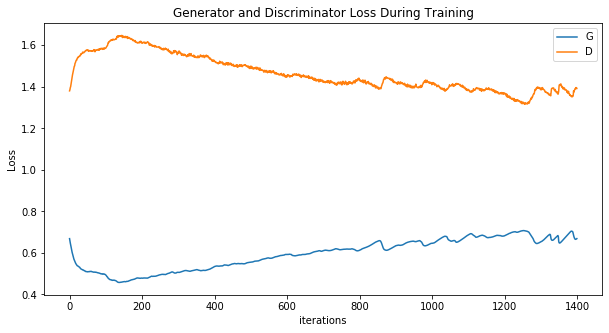

In [9]:
plot_train_loss()

# Animation

In [10]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

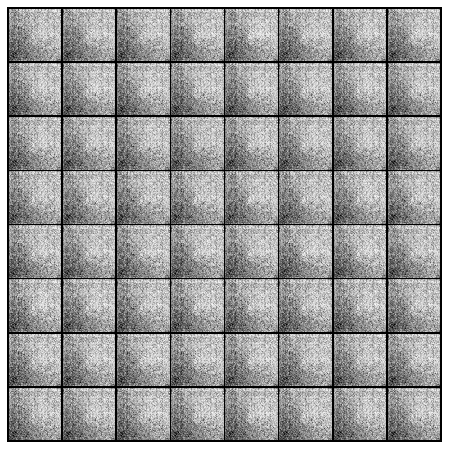

In [11]:
animate_gen_imgs()

# Anomaly Loss

In [12]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)

def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    _, Test_Data_feature = D(Test_Data)
    _, G_Data_feature = D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))


test_data_root = "../../../OhSeHyeon/source/dataset/test/test_DualPhaseSteel"
test_data_set = dataset.ImageFolder(root = test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))


# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# Train Latent Space Z

In [13]:
latent_space = []
auc=[]

def train_latent_space():
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data = G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step == 400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss > 500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [14]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  1
[0]	 Ano_loss : 1646.9138  Sum_of_z : 5.6922
[200]	 Ano_loss : 1624.2462  Sum_of_z : 4.4860
[400]	 Ano_loss : 1616.2472  Sum_of_z : -0.5177
picture  2
[0]	 Ano_loss : 1504.1427  Sum_of_z : -0.5744
[200]	 Ano_loss : 1480.4586  Sum_of_z : -0.0042
[400]	 Ano_loss : 1478.0155  Sum_of_z : -0.1598
picture  3
[0]	 Ano_loss : 2171.4915  Sum_of_z : -0.1169
[200]	 Ano_loss : 2163.8406  Sum_of_z : 10.5623
[400]	 Ano_loss : 2162.1604  Sum_of_z : 14.8030
picture  4
[0]	 Ano_loss : 1472.6702  Sum_of_z : 14.6895
[200]	 Ano_loss : 1463.6240  Sum_of_z : 10.4157
[400]	 Ano_loss : 1462.4456  Sum_of_z : 9.1315
picture  5
[0]	 Ano_loss : 2486.1106  Sum_of_z : 9.1377
[200]	 Ano_loss : 2471.6628  Sum_of_z : 12.1583
[400]	 Ano_loss : 2469.2268  Sum_of_z : 13.5984
picture  6
[0]	 Ano_loss : 1448.7689  Sum_of_z : 13.5609
[200]	 Ano_loss : 1443.0942  Sum_of_z : 8.1404
[400]	 Ano_loss : 1442.6140  Sum_of_z : 10.2683
picture  7
[0]	 Ano_loss : 1355.5048  Sum_of_z : 10.2405
[200]	 Ano_loss : 1345.9731  S

---

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# Similar Z , Ano_Score and Segementation


In [16]:
diff_cnts = []
diff_points = []
anomaly_imgs = []


def compare_imgs(real_img, generated_img, i, reverse=False, threshold=50):
    global anomaly_img
    
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i] == 0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

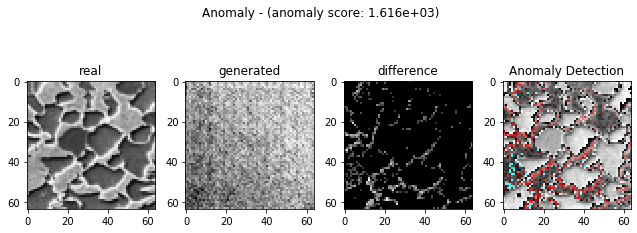

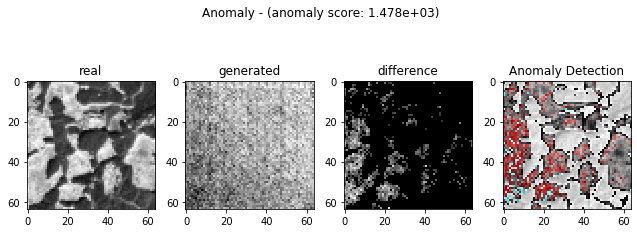

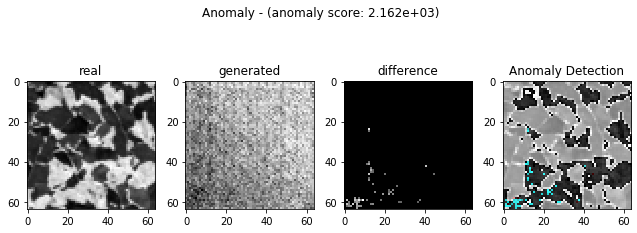

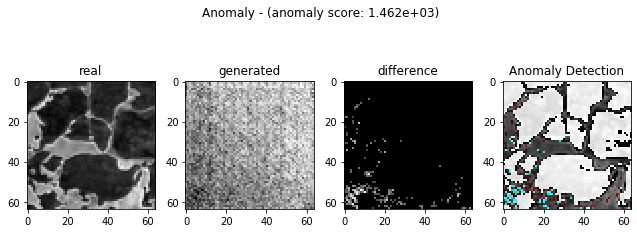

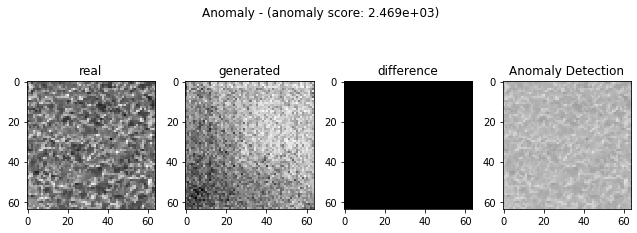

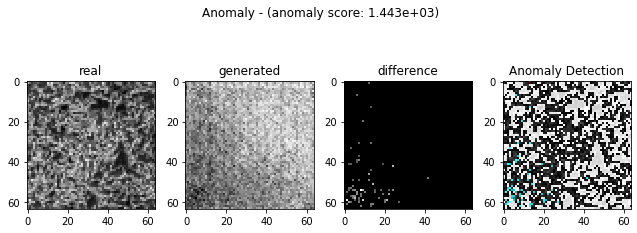

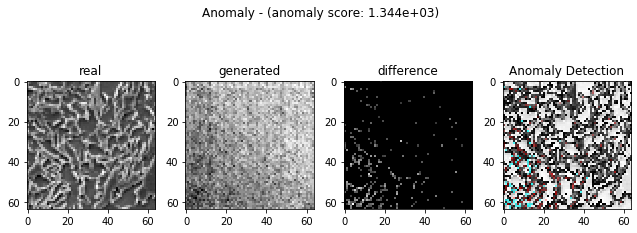

In [17]:
for i,data in enumerate(test_data_loader,0):
    test_img = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z = latent_space[i]
    R_img = test_img
    G_img = G(update_z).to(device)
    
    if i in [9]:
        compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.14526367 0.19970703 0.01391602 0.04931641 0.         0.01611328
 0.06591797]


---

# 분산 추출

In [ ]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# 모델 저장 및 읽기

In [ ]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "G" : G.state_dict(),
        #"latent_space" : latent_space.state_dict(), # nn.model만 가지는 기능
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [ ]:
save_pretrained()

In [ ]:
pretrained_D = Discriminator().to(device)
pretrained_G = Generator().to(device)
#pretrained_latent_space = [] # 다시 학습해야 함

def load_pretrained():
    global pretrained_D
    global pretrained_G
    #global pretrained_latent_space
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_G.load_state_dict(pretrained["G"])
    #pretrained_latent_space.load_state_dict(pretrained["latent_space"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_G)
    #print("pretrained_latent_space :", pretrained_latent_space)

In [ ]:
load_pretrained()

In [ ]:
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature = pretrained_D(Test_Data)
    _, G_Data_feature = pretrained_D(G_Data)
    residual_loss = torch.sum(torch.abs(Test_Data - G_Data))
    discrimination_loss = torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    ano_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    return ano_loss

In [ ]:
# train latent_space

latent_space = []
auc = []

def train_latent_space():
    global latent_space
    global auc
    
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)
        print("picture ", i+1)
        for step in range(401):

            G_Data   = pretrained_G(latent_vector)
            ano_loss = Anomaly_loss(test_img, G_Data)

            z_optimizer.zero_grad()

            # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
            # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
            ano_loss.backward(retain_graph = True)

            z_optimizer.step()

            if step%200 == 0:

                loss   = ano_loss.item()
                noises = torch.sum(latent_vector).item()
                print("[%d]\t Ano_loss : %.4f  Sum_of_z : %.4f" %(step,loss,noises))
                if step==400:
                    latent_space.append(latent_vector.cpu().data.numpy())
                    if loss>500:
                        auc.append(1)
                    else :
                        auc.append(0)

In [ ]:
train_latent_space()

latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

In [ ]:
def test():
    for i,data in enumerate(test_data_loader,0):
        test_img = data[0].to(device)

        #for i in range(len(latent_space)):
        update_z = latent_space[i]
        R_img = test_img
        G_img = pretrained_G(update_z).to(device)

        if i in [9]:
            compare_imgs(R_img, G_img,i,reverse = True, threshold = 50)
        else:
            compare_imgs(R_img, G_img,i,reverse = False, threshold = 50)

In [ ]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [ ]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

In [ ]:
cal_corr_coeffis()

print(corr_coeffis)

---

# anomaly detection 이미지 추출

In [ ]:
anomaly_imgs

# 이미지 저장 함수

In [ ]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [ ]:
save_imgs("./anomaly_imgs", anomaly_imgs)

---

# 티타늄(Ti64) 상대 밀도 계산

In [ ]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)